

第五部分：无监督学习
第10课：聚类分析
10.1 聚类分析概述
聚类是无监督学习的重要方法，目标是将相似的数据点分组：

* **无标签学习**：不需要预先定义的类别标签
* **相似性度量**：基于距离或密度等指标
* **探索性分析**：发现数据中的自然分组
* **应用场景**：客户细分、图像分割、异常检测等

主要聚类方法：

* **划分聚类**：K-Means, K-Medoids
* **层次聚类**：凝聚式、分裂式
* **密度聚类**：DBSCAN, OPTICS
* **基于模型**：高斯混合模型

---
10.2 K-Means聚类
10.2.1 K-Means原理和实现
```python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs, load_iris, load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples

# 创建示例数据
X, y_true = make_blobs(n_samples=300, centers=4, n_features=2,
                       cluster_std=0.6, random_state=42)

# 可视化原始数据
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=50, alpha=0.8)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Original Data')
plt.grid(True, alpha=0.3)
plt.show()

# 应用K-Means
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto') # Added n_init for future versions
y_kmeans = kmeans.fit_predict(X)

# 可视化聚类结果
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis', alpha=0.8)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.8,
            marker='*', edgecolor='black', linewidth=2)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-Means Clustering Results')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Cluster centers:\n{centers}")
print(f"Inertia (within-cluster sum of squares): {kmeans.inertia_:.2f}")
```

---
10.2.2 K-Means算法步骤可视化
```python
def plot_kmeans_steps(X, n_clusters=3, max_iters=6):
    """可视化K-Means的迭代过程"""
    np.random.seed(42)

    # 初始化随机中心
    indices = np.random.choice(X.shape[0], n_clusters, replace=False)
    centers = X[indices]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    old_centers = centers.copy() # Initialize old_centers before the loop

    for i in range(max_iters):
        # 分配到最近的中心
        distances = np.sqrt(((X - centers[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)

        # 绘图
        ax = axes[i]
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis', alpha=0.6)
        ax.scatter(centers[:, 0], centers[:, 1], c='red', s=200,
                  marker='*', edgecolor='black', linewidth=2)
        ax.set_title(f'Iteration {i+1}')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.grid(True, alpha=0.3)

        # 更新中心
        new_centers = np.array([X[labels == k].mean(axis=0) for k in range(n_clusters)])

        # 画出移动路径
        # Check if old_centers is defined and centers are different
        if i > 0: # old_centers was defined in the previous iteration
            for j in range(n_clusters):
                ax.plot([old_centers[j, 0], centers[j, 0]],
                       [old_centers[j, 1], centers[j, 1]],
                       'k--', alpha=0.5, linewidth=1)

        old_centers = centers.copy() # Update old_centers for the next iteration's path drawing
        centers = new_centers

        # 检查收敛
        if i > 0 and np.allclose(old_centers, centers):
            ax.text(0.5, 0.95, 'Converged!', transform=ax.transAxes,
                   ha='center', va='top', fontsize=12, color='green',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            # 隐藏剩余的子图
            for j_ax in range(i + 1, len(axes)): # Iterate up to len(axes)
                axes[j_ax].axis('off')
            break
    # Ensure all remaining axes are turned off if max_iters is reached before convergence
    # or if convergence happens early and fewer than 6 plots are made.
    for j_ax in range(i + 1, len(axes)):
        axes[j_ax].axis('off')


    plt.tight_layout()
    plt.show()

# 演示K-Means步骤
# Re-create X if it's not in the current scope from 10.2.1
X_steps, _ = make_blobs(n_samples=300, centers=4, n_features=2, # Renamed to X_steps to avoid conflict
                       cluster_std=0.6, random_state=42)
plot_kmeans_steps(X_steps)
```

---
10.2.3 选择最佳K值 - 肘部法则
```python
# 肘部法则
K_range = range(1, 11)
inertias = []
silhouette_scores = []

# Using X from 10.2.1
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto') # Added n_init
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

    if k > 1:  # silhouette score需要至少2个簇
        score = silhouette_score(X, kmeans.labels_)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(np.nan) # Use NaN for k=1 for silhouette

# 可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 肘部图
ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of clusters (K)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
# The original code hardcoded x=4. It's better to find it or not draw it if not explicitly calculated.
# For demonstration, we'll keep it as it was in the original.
ax1.axvline(x=4, color='r', linestyle='--', alpha=0.5, label='Elbow at K=4')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 轮廓系数图
# Plotting only for k > 1 where silhouette_scores are actual numbers
ax2.plot(K_range[1:], silhouette_scores[1:], 'go-') # Adjusted K_range and scores
ax2.set_xlabel('Number of clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis')
ax2.axvline(x=4, color='r', linestyle='--', alpha=0.5, label='Best at K=4') # As per original
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Elbow method suggests K=4 (visually)")
# Find best silhouette score programmatically
valid_silhouette_scores = [s for s in silhouette_scores if not np.isnan(s)]
if valid_silhouette_scores:
    best_score = max(valid_silhouette_scores)
    best_k_silhouette = K_range[silhouette_scores.index(best_score)]
    print(f"Best silhouette score: {best_score:.3f} at K={best_k_silhouette}")
else:
    print("Not enough clusters to calculate a meaningful silhouette score.")

```

---
10.2.4 轮廓分析详细可视化
```python
from matplotlib import cm

def plot_silhouette_analysis(X_data, n_clusters_to_plot): # Renamed X to X_data
    """详细的轮廓分析"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.set_facecolor('white') # Setting background for better visibility if saved

    # 聚类
    clusterer = KMeans(n_clusters=n_clusters_to_plot, random_state=42, n_init='auto') # Added n_init
    cluster_labels = clusterer.fit_predict(X_data)

    # 计算轮廓系数
    silhouette_avg = silhouette_score(X_data, cluster_labels)
    sample_silhouette_values = silhouette_samples(X_data, cluster_labels)

    # 绘制轮廓图
    y_lower = 10
    for i in range(n_clusters_to_plot):
        # 获取簇i的轮廓系数并排序
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters_to_plot)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # 标记簇编号
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the next plot

    ax1.set_title(f'Silhouette Plot (n_clusters = {n_clusters_to_plot})')
    ax1.set_xlabel('Silhouette Coefficient')
    ax1.set_ylabel('Cluster Label')
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--",
                label=f'Average: {silhouette_avg:.3f}')
    ax1.legend(loc='best') # Changed to 'best'
    ax1.set_yticks([]) # Clear y-axis ticks
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.2)) # Corrected set_xlim to set_xticks for range like display
    ax1.set_xlim([-0.1, 1])


    # 绘制聚类结果
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters_to_plot)
    ax2.scatter(X_data[:, 0], X_data[:, 1], marker='.', s=100, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # 绘制聚类中心
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=100, edgecolor='k') # Changed s to be consistent

    ax2.set_title(f'Clustered Data (n_clusters = {n_clusters_to_plot})')
    ax2.set_xlabel('Feature 1')
    ax2.set_ylabel('Feature 2')
    ax2.grid(True, alpha=0.3) # Added grid for consistency

    plt.suptitle((f"Silhouette analysis for KMeans clustering on sample data "
                  f"with n_clusters = {n_clusters_to_plot}"),
                 fontsize=14, fontweight='bold') # Added suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout for suptitle
    plt.show()

# 对不同K值进行轮廓分析
# Using X from 10.2.1
for n_clusters_iter in [2, 3, 4, 5]: # Renamed n_clusters to n_clusters_iter
    plot_silhouette_analysis(X, n_clusters_iter)
```

---
10.2.5 K-Means++初始化
```python
# 比较随机初始化和K-Means++
n_init_methods = 2 # This variable is not directly used later, but defined in original
init_methods = ['random', 'k-means++']
results_init = [] # Renamed to avoid conflict

# 多次运行以显示初始化的影响
# Using X from 10.2.1
for method in init_methods:
    inertias_method = [] # Renamed
    for _ in range(20):
        # For 'random' init, n_init=1 is fine.
        # For 'k-means++', n_init default is 10 in scikit-learn >= 0.23.
        # The original code used n_init=1 for k-means++ too, which relies on a single run of k-means++.
        # To truly compare, one might want to let k-means++ run multiple times (n_init > 1)
        # or stick to n_init=1 for both to compare single initialization procedures.
        # Sticking to original's n_init=1 for this reproduction.
        kmeans = KMeans(n_clusters=4, init=method, n_init=1, random_state=None) # random_state=None for variability
        kmeans.fit(X)
        inertias_method.append(kmeans.inertia_)
    results_init.append(inertias_method)

# 可视化比较
plt.figure(figsize=(10, 6))
plt.boxplot(results_init, labels=init_methods)
plt.ylabel('Inertia')
plt.title('K-Means Initialization Methods Comparison (Inertia)') # Added Inertia to title
plt.grid(True, alpha=0.3, axis='y')
plt.show()

print("Statistics for Inertia:")
for method, inertias_vals in zip(init_methods, results_init): # Renamed inertias
    print(f"{method}: mean={np.mean(inertias_vals):.2f}, std={np.std(inertias_vals):.2f}")
```

---
10.3 层次聚类
10.3.1 凝聚式层次聚类
```python
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage # linkage was already imported by name
from sklearn.datasets import make_moons

# 创建不同形状的数据集
datasets_hierarchical = [] # Renamed

# 数据集1: blobs
X1_h, y1_h = make_blobs(n_samples=150, centers=3, n_features=2, # Renamed variables
                    cluster_std=0.5, random_state=42)
datasets_hierarchical.append((X1_h, "Blobs"))

# 数据集2: moons
X2_h, y2_h = make_moons(n_samples=150, noise=0.1, random_state=42) # Renamed variables
datasets_hierarchical.append((X2_h, "Moons"))

# 数据集3: 不同密度
X3_1_h, _ = make_blobs(n_samples=100, centers=1, n_features=2, # Renamed variables
                     cluster_std=0.3, center_box=(-2, -2), random_state=42)
X3_2_h, _ = make_blobs(n_samples=100, centers=1, n_features=2, # Renamed variables
                     cluster_std=0.8, center_box=(2, 2), random_state=42)
X3_h = np.vstack([X3_1_h, X3_2_h]) # Renamed variables
datasets_hierarchical.append((X3_h, "Different Densities"))

# 对每个数据集应用层次聚类
linkage_methods = ['ward', 'complete', 'average', 'single']

# Determine n_clusters for each dataset (original code uses 2 for all)
# For blobs, we know it's 3. For moons, 2. For different densities, 2.
# The original used n_clusters=2, so we'll stick to that.
n_clusters_agg = 2

fig, axes = plt.subplots(len(datasets_hierarchical), len(linkage_methods),
                        figsize=(16, 12), facecolor='white')

for i, (X_data_h, name_h) in enumerate(datasets_hierarchical): # Renamed variables
    for j, linkage_method in enumerate(linkage_methods):
        # 聚类
        # 'ward' linkage must be used with a distance metric that supports it (e.g., Euclidean)
        # and typically n_clusters is specified.
        if linkage_method == 'ward':
            # Ward is defined only if compute_full_tree is True or n_clusters is not None.
             clustering = AgglomerativeClustering(n_clusters=n_clusters_agg if name_h != "Blobs" else 3, # Adjust for blobs
                                               linkage=linkage_method)
        else:
             clustering = AgglomerativeClustering(n_clusters=n_clusters_agg if name_h != "Blobs" else 3, # Adjust for blobs
                                               linkage=linkage_method)

        labels = clustering.fit_predict(X_data_h)

        # 绘图
        ax = axes[i, j]
        scatter = ax.scatter(X_data_h[:, 0], X_data_h[:, 1], c=labels, cmap='viridis',
                           s=30, alpha=0.8) # Reduced s for clarity

        if i == 0:
            ax.set_title(f'{linkage_method.capitalize()} Linkage')
        if j == 0:
            ax.set_ylabel(name_h, fontsize=12) # Increased fontsize

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal', adjustable='box') # Maintain aspect ratio

plt.tight_layout()
plt.show()
```

---
10.3.2 树状图（Dendrogram）
```python
# 使用鸢尾花数据集
iris = load_iris()
X_iris = iris.data
y_iris = iris.target # y_iris contains class labels, not sample indices for dendrogram labels

# 标准化
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)

# 计算链接矩阵
linkage_matrix = linkage(X_iris_scaled, method='ward')

# 绘制树状图
plt.figure(figsize=(15, 8), facecolor='white')
dendrogram(linkage_matrix,
           orientation='top',
           # labels=y_iris, # labels expects individual sample labels, not class labels.
           # If you want to color by class, you'd need a more complex setup or use libraries that support it directly.
           # For simplicity, removing labels or using sample indices.
           # labels=[str(i) for i in range(X_iris_scaled.shape[0])], # Example: using sample indices
           truncate_mode='lastp', # Show only the last p merged clusters
           p=12, # Example: show last 12 merges
           show_leaf_counts=True,
           leaf_rotation=90.,
           leaf_font_size=8.,
           show_contracted=True, # To visualize hierarchies better
           distance_sort='descending') # Already default but good to specify

plt.title('Hierarchical Clustering Dendrogram (Iris Dataset - Ward Linkage)')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance (Ward)')

# 添加切割线
plt.axhline(y=7.5, c='r', linestyle='--', label='Cut at distance=7.5 (example)') # Adjusted y for Ward on Iris
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add y-grid
plt.show()

# 根据树状图确定簇数
from scipy.cluster.hierarchy import fcluster
max_d = 7.5  # 切割距离 (example, chosen based on visual inspection of the dendrogram)
clusters_dendro = fcluster(linkage_matrix, max_d, criterion='distance')
print(f"Number of clusters by cutting at distance {max_d}: {len(np.unique(clusters_dendro))}")

# If we aim for 3 clusters (since Iris has 3 classes)
clusters_k3 = fcluster(linkage_matrix, 3, criterion='maxclust')
print(f"Number of clusters by specifying k=3: {len(np.unique(clusters_k3))}")

```

---
10.3.3 不同链接方法的比较
```python
# 创建一个有明显层次结构的数据集
np.random.seed(42)
# 创建三个主簇，每个主簇包含两个子簇
n_points_hier = 50 # Renamed
clusters_data_h = [] # Renamed

# 主簇1
clusters_data_h.append(np.random.randn(n_points_hier, 2) * 0.5 + [-5, 0])
clusters_data_h.append(np.random.randn(n_points_hier, 2) * 0.5 + [-3, 0])

# 主簇2
clusters_data_h.append(np.random.randn(n_points_hier, 2) * 0.5 + [0, 5])
clusters_data_h.append(np.random.randn(n_points_hier, 2) * 0.5 + [0, 3])

# 主簇3
clusters_data_h.append(np.random.randn(n_points_hier, 2) * 0.5 + [5, 0])
clusters_data_h.append(np.random.randn(n_points_hier, 2) * 0.5 + [3, 0])

X_hierarchical_comp = np.vstack(clusters_data_h) # Renamed

# 比较不同链接方法
fig, axes = plt.subplots(2, 4, figsize=(20, 10), facecolor='white')

linkage_methods_comp = ['single', 'complete', 'average', 'ward'] # Renamed

for i, method in enumerate(linkage_methods_comp):
    # 计算链接
    Z = linkage(X_hierarchical_comp, method=method)

    # 绘制树状图
    ax = axes[0, i]
    dendrogram(Z, ax=ax, color_threshold=0, above_threshold_color='k',
               truncate_mode='lastp', p=30) # Added truncate for clarity
    ax.set_title(f'{method.capitalize()} Linkage Dendrogram')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Distance')
    ax.set_xticks([]) # Hide x-ticks for dendrogram clarity

    # 绘制聚类结果（3个簇）
    ax = axes[1, i]
    # AgglomerativeClustering requires n_clusters if not computing full tree.
    # For 'ward', it's common to specify n_clusters.
    # For others, you might cut the dendrogram (fcluster) or specify n_clusters.
    clustering_comp = AgglomerativeClustering(n_clusters=3, linkage=method) # Original uses 3 clusters
    labels_comp = clustering_comp.fit_predict(X_hierarchical_comp)

    ax.scatter(X_hierarchical_comp[:, 0], X_hierarchical_comp[:, 1],
              c=labels_comp, cmap='viridis', s=30, alpha=0.7) # Reduced s
    ax.set_title(f'{method.capitalize()} - 3 Clusters')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')


plt.tight_layout()
plt.show()
```

---
10.4 DBSCAN（基于密度的聚类）
10.4.1 DBSCAN原理和实现
```python
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons, make_circles # make_circles already imported

# 创建复杂形状的数据集
fig, axes = plt.subplots(2, 3, figsize=(16, 10), facecolor='white') # Increased width slightly

# 数据集1: Moons
X_moons_db, _ = make_moons(n_samples=200, noise=0.05, random_state=42) # Reduced noise for better DBSCAN demo

# 数据集2: Circles
X_circles_db, _ = make_circles(n_samples=200, noise=0.05, factor=0.5, random_state=42) # Reduced noise

# 数据集3: 混合数据
X_mixed_db = np.vstack([ # Renamed
    np.random.randn(100, 2) * 0.5 + [2, 2],
    np.random.randn(50, 2) * 0.5 + [-2, -2],
    np.random.randn(50, 2) * 0.5 + [2, -2],
    np.random.uniform(-4, 4, (20, 2))  # 噪声点
])

datasets_db = [(X_moons_db, "Moons", {'eps': 0.3, 'min_samples': 5}, 2), # Added params for DBSCAN and k for K-Means
               (X_circles_db, "Circles", {'eps': 0.3, 'min_samples': 5}, 2),
               (X_mixed_db, "Mixed with Noise", {'eps': 0.4, 'min_samples': 5}, 3)] # Adjusted params for mixed

dbscan_outputs = [] # To store dbscan labels for later printing

# 对每个数据集应用K-Means和DBSCAN
for i, (X_data_db, name_db, db_params, k_kmeans) in enumerate(datasets_db): # Renamed variables
    # K-Means
    kmeans = KMeans(n_clusters=k_kmeans, random_state=42, n_init='auto') # Added n_init
    kmeans_labels = kmeans.fit_predict(X_data_db)

    # DBSCAN
    dbscan = DBSCAN(eps=db_params['eps'], min_samples=db_params['min_samples'])
    dbscan_labels = dbscan.fit_predict(X_data_db)
    dbscan_outputs.append((name_db, dbscan_labels))


    # 绘制K-Means结果
    ax = axes[0, i]
    ax.scatter(X_data_db[:, 0], X_data_db[:, 1], c=kmeans_labels,
                        cmap='viridis', s=40, alpha=0.8) # Adjusted s
    ax.set_title(f'K-Means on {name_db}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')


    # 绘制DBSCAN结果
    ax = axes[1, i]
    unique_labels = set(dbscan_labels)
    # Ensure consistent color mapping, noise is always red
    colors = plt.cm.get_cmap('viridis', len(unique_labels) - (1 if -1 in unique_labels else 0) )

    color_map = {}
    cluster_idx = 0
    for k_label in sorted(list(unique_labels)): # Sort labels for consistent color assignment
        if k_label == -1:
            color_map[k_label] = 'red'
        else:
            color_map[k_label] = colors(cluster_idx)
            cluster_idx += 1

    for k_label in unique_labels:
        class_member_mask = (dbscan_labels == k_label)
        xy = X_data_db[class_member_mask]
        marker = 'x' if k_label == -1 else 'o'
        ax.scatter(xy[:, 0], xy[:, 1], c=[color_map[k_label]], marker=marker,
                  s=40, alpha=0.8, edgecolor='black' if k_label == -1 else 'none',
                  label=f'Cluster {k_label}' if k_label !=-1 else 'Noise')


    ax.set_title(f'DBSCAN on {name_db} (eps={db_params["eps"]}, min_s={db_params["min_samples"]})') # Show params
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')
    if i == 0: # Legend for the first DBSCAN plot
        handles, labels_legend = ax.get_legend_handles_labels()
        # Filter out duplicate noise labels if any, and sort
        by_label = dict(zip(labels_legend, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='best', fontsize='small')


plt.tight_layout()
plt.show()

# 打印DBSCAN结果统计
print("\nDBSCAN Results Statistics:")
for name_db, labels_db in dbscan_outputs: # Using stored labels
    n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
    n_noise_db = list(labels_db).count(-1)
    print(f"\n{name_db}:")
    print(f"  Number of clusters found: {n_clusters_db}")
    print(f"  Number of noise points: {n_noise_db}")
```

---
10.4.2 DBSCAN参数调优
```python
# 参数网格搜索
def plot_dbscan_params(X_db_param, eps_range_param, min_samples_range_param): # Renamed vars
    """可视化不同参数组合的DBSCAN结果"""
    num_eps = len(eps_range_param)
    num_min_samples = len(min_samples_range_param)
    fig, axes = plt.subplots(num_min_samples, num_eps,
                            figsize=(num_eps * 3.5, num_min_samples * 3), # Adjusted figsize
                            facecolor='white', sharex=True, sharey=True) # Added sharex/y

    for i, min_samples_val in enumerate(min_samples_range_param): # Renamed var
        for j, eps_val in enumerate(eps_range_param): # Renamed var
            # 应用DBSCAN
            dbscan = DBSCAN(eps=eps_val, min_samples=min_samples_val)
            labels = dbscan.fit_predict(X_db_param)

            # 绘图
            ax = axes[i, j] if num_min_samples > 1 and num_eps > 1 else (axes[j] if num_eps > 1 else axes[i] if num_min_samples > 1 else axes)


            # 统计信息
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)

            # 绘制结果
            unique_labels = set(labels)
            # Consistent color mapping
            colors_param = plt.cm.get_cmap('viridis', len(unique_labels) - (1 if -1 in unique_labels else 0) )
            color_map_param = {}
            cluster_idx_param = 0
            for k_label in sorted(list(unique_labels)):
                if k_label == -1:
                    color_map_param[k_label] = 'red'
                else:
                    color_map_param[k_label] = colors_param(cluster_idx_param)
                    cluster_idx_param +=1

            for k_label in unique_labels:
                class_member_mask = (labels == k_label)
                xy = X_db_param[class_member_mask]
                marker = 'x' if k_label == -1 else '.' # Use '.' for denser plots
                ax.scatter(xy[:, 0], xy[:, 1], c=[color_map_param[k_label]], s=15, alpha=0.7, # Reduced s
                          marker=marker)

            ax.set_title(f'eps={eps_val}, min_s={min_samples_val}\nCl: {n_clusters}, Noi: {n_noise}',
                         fontsize=9) # Reduced fontsize
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect('equal', adjustable='box')


    fig.suptitle('DBSCAN Parameter Tuning (Moons Dataset)', fontsize=14, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust for suptitle
    plt.show()

# 使用Moons数据集测试参数 (X_moons_db from 10.4.1)
eps_range_test = [0.1, 0.2, 0.3, 0.5] # Renamed
min_samples_range_test = [3, 5, 7, 10] # Renamed, adjusted values
plot_dbscan_params(X_moons_db, eps_range_test, min_samples_range_test)
```

---
10.4.3 寻找最佳eps值 - k距离图
```python
from sklearn.neighbors import NearestNeighbors

def plot_k_distance(X_k_dist, k_val, dataset_name="Dataset"): # Renamed X, k and added dataset_name
    """绘制k距离图来帮助选择eps"""
    # 计算每个点到第k个最近邻的距离
    # k_val for NearestNeighbors should be min_samples (or min_samples - 1 by some conventions)
    # If min_samples is chosen for DBSCAN, k for k-distance plot is often min_samples.
    # The original code used k=5, implying min_samples=5.
    nbrs = NearestNeighbors(n_neighbors=k_val).fit(X_k_dist)
    distances, indices = nbrs.kneighbors(X_k_dist)

    # 获取第k个最近邻的距离（索引k-1 because kneighbors returns the point itself as 1st neighbor if include_self=True (default))
    # distances are already sorted for each point's neighbors if algorithm='auto'
    # We need the distance to the k-th neighbor, which is at column k-1
    k_distances = np.sort(distances[:, k_val-1], axis=0) # Sort these k-th distances

    # 绘图
    plt.figure(figsize=(10, 6), facecolor='white')
    plt.plot(range(len(k_distances)), k_distances) # Plot against index
    plt.xlabel(f'Points sorted by distance to {k_val}-th nearest neighbor')
    plt.ylabel(f'{k_val}-th Nearest Neighbor Distance (eps candidate)')
    plt.title(f'{k_val}-Distance Graph for {dataset_name} (eps selection)')
    plt.grid(True, alpha=0.5, linestyle='--')

    # 尝试找到"肘部" - This is a heuristic and can be tricky.
    # A more robust way might involve libraries like 'kneed'
    # Original's second derivative approach is sensitive.
    # For simplicity, we'll show the plot and user can infer.
    # Or, if we want to suggest a point:
    if len(k_distances) > k_val +1 : # Ensure enough points for diff
        try:
            from kneed import KneeLocator
            kn = KneeLocator(range(len(k_distances)), k_distances, curve='convex', direction='increasing')
            if kn.elbow_y:
                 plt.axhline(y=kn.elbow_y, color='r', linestyle='--',
                           label=f'Suggested eps (knee) ≈ {kn.elbow_y:.3f}')
                 plt.plot(kn.elbow, kn.elbow_y, 'ro', markersize=8) # Mark the elbow point
                 plt.legend()
        except ImportError:
            print("Consider installing 'kneed' library for automatic elbow detection.")
            # Fallback to a simpler visual cue if kneed is not available
            # This simple diff method is often not robust
            if len(k_distances) > 100: # Only if enough points for a smooth diff
                 first_diff = np.diff(k_distances,1)
                 second_diff = np.diff(first_diff,1)
                 if len(second_diff) > 0 :
                    elbow_idx = np.argmax(second_diff) + 2 # +1 for first diff, +1 for second diff index
                    if elbow_idx < len(k_distances):
                        elbow_value = k_distances[elbow_idx]
                        plt.axhline(y=elbow_value, color='g', linestyle=':',
                                   label=f'Approx. eps (max curvature) ≈ {elbow_value:.3f}')
                        plt.legend()


    plt.show()
    return k_distances

# 对不同数据集绘制k距离图 (Using X_moons_db, X_circles_db from 10.4.1)
# The k value for k-distance plot is typically related to min_samples for DBSCAN.
# Let's assume min_samples will be around 5-10 for these datasets.
min_samples_for_k_dist = 5

print(f"\nK-Distance plot for k={min_samples_for_k_dist}")
for X_data_k_dist, name_k_dist in [(X_moons_db, "Moons"), (X_circles_db, "Circles")]: # Renamed vars
    print(f"\nAnalyzing {name_k_dist} dataset:")
    k_distances_plot = plot_k_distance(X_data_k_dist, k=min_samples_for_k_dist, dataset_name=name_k_dist)
    # Heuristic: an eps around the "elbow" of this plot.
    # For X_moons_db with min_samples=5, eps might be around 0.15-0.3 from visual.
    # For X_circles_db with min_samples=5, eps might be around 0.15-0.3 from visual.
```

---
10.5 聚类评估指标
```python
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, completeness_score, v_measure_score

# 创建一个函数来评估不同聚类算法
def evaluate_clustering(X_eval_data, algorithms_dict, true_labels_eval=None): # Renamed variables
    """评估多个聚类算法"""
    results_list = [] # Renamed

    for name, algorithm_instance in algorithms_dict.items(): # Renamed variables
        # 聚类
        # Some algorithms might be pre-fitted if passed with labels_
        if hasattr(algorithm_instance, 'labels_') and algorithm_instance.labels_ is not None:
            labels = algorithm_instance.labels_
        else:
            try:
                labels = algorithm_instance.fit_predict(X_eval_data)
            except TypeError: # For algorithms like LDA that need y for fit
                if true_labels_eval is not None:
                    # This case is tricky for clustering evaluation as it implies supervised
                    print(f"Algorithm {name} seems to require labels for fitting, skipping unsupervised eval or assuming prefit.")
                    continue
                else:
                    print(f"Algorithm {name} requires y for fit, and true_labels not provided. Skipping.")
                    continue


        n_clusters_found = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_points = list(labels).count(-1)

        current_result = {
            'Algorithm': name,
            'Clusters': n_clusters_found,
            'Noise': n_noise_points
        }

        # 计算内部评估指标
        # Ensure there's more than 1 cluster and not all points are noise for these metrics
        if n_clusters_found > 1 and (len(labels) - n_noise_points) > n_clusters_found :
            # Filter out noise points for silhouette, CH, DB scores if present
            valid_mask = labels != -1
            if np.sum(valid_mask) > 1: # Ensure some non-noise points exist
                X_eval_filtered = X_eval_data[valid_mask]
                labels_filtered = labels[valid_mask]
                if len(set(labels_filtered)) > 1: # Check again after filtering noise
                    current_result['Silhouette'] = silhouette_score(X_eval_filtered, labels_filtered)
                    current_result['Calinski-Harabasz'] = calinski_harabasz_score(X_eval_filtered, labels_filtered)
                    current_result['Davies-Bouldin'] = davies_bouldin_score(X_eval_filtered, labels_filtered)
                else:
                    current_result['Silhouette'] = current_result['Calinski-Harabasz'] = current_result['Davies-Bouldin'] = np.nan
            else: # All points are noise or only one cluster of non-noise
                current_result['Silhouette'] = current_result['Calinski-Harabasz'] = current_result['Davies-Bouldin'] = np.nan
        else: # Not enough clusters or data points for these scores
            current_result['Silhouette'] = np.nan
            current_result['Calinski-Harabasz'] = np.nan
            current_result['Davies-Bouldin'] = np.nan

        # 如果有真实标签，计算外部评估指标
        if true_labels_eval is not None:
            # Filter out noise points from both true_labels and predicted labels
            mask = labels != -1
            if mask.sum() > 0: # If there are any non-noise predictions
                true_labels_masked = true_labels_eval[mask]
                predicted_labels_masked = labels[mask]
                # Ensure there's something to compare
                if len(true_labels_masked) > 0 and len(set(predicted_labels_masked)) > 0 :
                    current_result['ARI'] = adjusted_rand_score(true_labels_masked, predicted_labels_masked)
                    current_result['NMI'] = normalized_mutual_info_score(true_labels_masked, predicted_labels_masked, average_method='arithmetic')
                    current_result['Homogeneity'] = homogeneity_score(true_labels_masked, predicted_labels_masked)
                    current_result['Completeness'] = completeness_score(true_labels_masked, predicted_labels_masked)
                    current_result['V-measure'] = v_measure_score(true_labels_masked, predicted_labels_masked)
                else:
                    current_result['ARI'] = current_result['NMI'] = current_result['Homogeneity'] = current_result['Completeness'] = current_result['V-measure'] = np.nan
            else: # All predicted labels are noise
                 current_result['ARI'] = current_result['NMI'] = current_result['Homogeneity'] = current_result['Completeness'] = current_result['V-measure'] = np.nan


        results_list.append(current_result)

    return pd.DataFrame(results_list)

# 使用有真实标签的数据集
X_eval, y_true_eval = make_blobs(n_samples=300, centers=4, n_features=2, # Renamed y_true
                           cluster_std=0.7, random_state=42) # Slightly increased std
X_eval_scaled = StandardScaler().fit_transform(X_eval) # Scale data for distance-based algos

# 定义算法
algorithms_eval = { # Renamed
    'K-Means (k=4)': KMeans(n_clusters=4, random_state=42, n_init='auto'),
    'K-Means (k=3)': KMeans(n_clusters=3, random_state=42, n_init='auto'),
    'K-Means (k=5)': KMeans(n_clusters=5, random_state=42, n_init='auto'),
    'Hierarchical (Ward, k=4)': AgglomerativeClustering(n_clusters=4, linkage='ward'),
    'Hierarchical (Complete, k=4)': AgglomerativeClustering(n_clusters=4, linkage='complete'),
    'Hierarchical (Average, k=4)': AgglomerativeClustering(n_clusters=4, linkage='average'),
    'DBSCAN (eps=0.8, ms=5)': DBSCAN(eps=0.8, min_samples=5), # Adjusted eps for scaled data
    'DBSCAN (eps=1.2, ms=5)': DBSCAN(eps=1.2, min_samples=5)  # Adjusted eps
}

# 评估
eval_results_df = evaluate_clustering(X_eval_scaled, algorithms_eval, y_true_eval) # Renamed
print("\nClustering Evaluation Results (on Scaled Data):")
# Define order of columns for better readability
column_order = ['Algorithm', 'Clusters', 'Noise', 'Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin', 'ARI', 'NMI', 'Homogeneity', 'Completeness', 'V-measure']
# Filter out columns that might not exist if true_labels_eval was None (though it's provided here)
final_columns = [col for col in column_order if col in eval_results_df.columns]
print(eval_results_df[final_columns].round(3))


# 可视化评估结果 (only metrics that are present)
metrics_to_plot = {
    'Silhouette': 'Higher is Better',
    'Davies-Bouldin': 'Lower is Better',
    'Calinski-Harabasz': 'Higher is Better',
    'ARI': 'Higher is Better (vs True Labels)',
    'NMI': 'Higher is Better (vs True Labels)',
    'V-measure': 'Higher is Better (vs True Labels)'
}
plot_cols = [m for m in metrics_to_plot.keys() if m in eval_results_df.columns and eval_results_df[m].notna().any()]

if plot_cols:
    num_metrics = len(plot_cols)
    fig_rows = (num_metrics + 1) // 2 # Arrange in 2 columns
    fig, axes = plt.subplots(fig_rows, 2, figsize=(15, fig_rows * 5), facecolor='white')
    axes = axes.flatten()

    for i, metric in enumerate(plot_cols):
        ax = axes[i]
        # Sort by metric for better visualization in bar chart
        sorted_df = eval_results_df.sort_values(by=metric, ascending=(metrics_to_plot[metric] == 'Lower is Better'))
        bars = ax.barh(sorted_df['Algorithm'], sorted_df[metric], color=plt.cm.viridis(np.linspace(0,1,len(sorted_df))))
        ax.set_title(f'{metric} ({metrics_to_plot[metric]})')
        ax.set_xlabel('Score')
        ax.grid(axis='x', linestyle='--', alpha=0.6)
        # Add labels to bars
        for bar in bars:
            width = bar.get_width()
            label_x_pos = width + (max(sorted_df[metric])*0.01) if metrics_to_plot[metric] == 'Higher is Better' else width - (max(sorted_df[metric])*0.1) # Adjust label pos
            if not np.isnan(width):
                ax.text(label_x_pos, bar.get_y() + bar.get_height()/2., f'{width:.3f}', va='center', ha='left' if metrics_to_plot[metric] == 'Higher is Better' else 'right')


    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
else:
    print("No metrics available to plot.")
```

---
第11课：降维技术
11.1 降维概述
降维的目标是减少数据的特征数量，同时保留最重要的信息：

* **维度诅咒**：高维空间中的数据稀疏性问题
* **可视化**：将高维数据投影到2D/3D空间
* **去噪**：去除冗余特征和噪声
* **计算效率**：减少计算复杂度

主要降维方法：

* **线性方法**：PCA、LDA
* **非线性方法**：t-SNE、UMAP
* **基于自编码器**：深度学习方法

---
11.2 主成分分析（PCA）
11.2.1 PCA原理和实现
```python
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits, fetch_olivetti_faces # fetch_olivetti_faces already imported

# 使用手写数字数据集
digits = load_digits()
X_digits = digits.data # Renamed
y_digits = digits.target # Renamed

print(f"Original data shape: {X_digits.shape}")
print(f"Number of features: {X_digits.shape[1]}")

# Scale data before PCA for better results, though PCA works on unscaled data by centering it.
# Scaling is important if features have very different variances. For digits, pixels are somewhat comparable.
scaler_digits = StandardScaler()
X_digits_scaled = scaler_digits.fit_transform(X_digits)


# 应用PCA
pca_2c = PCA(n_components=2) # Renamed
X_pca_2c = pca_2c.fit_transform(X_digits_scaled) # Use scaled data

# 可视化降维结果
plt.figure(figsize=(10, 8), facecolor='white')
scatter = plt.scatter(X_pca_2c[:, 0], X_pca_2c[:, 1], c=y_digits, cmap='tab10',
                     alpha=0.7, edgecolor='none', s=40) # Adjusted alpha, edgecolor, s
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Digits Dataset (2 Components from Scaled Data)')
plt.colorbar(scatter, label='Digit Class') # Changed label
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

print(f"\nExplained variance ratio by 2 components: {pca_2c.explained_variance_ratio_}")
print(f"Total variance explained by 2 components: {sum(pca_2c.explained_variance_ratio_):.2%}")
```

---
11.2.2 选择主成分数量
```python
# 计算所有主成分 (using X_digits_scaled from 11.2.1)
pca_full = PCA() # n_components=None by default, meaning all components
pca_full.fit(X_digits_scaled)

# 累积方差解释率
explained_variance_ratio_all = pca_full.explained_variance_ratio_
cumsum_ratio = np.cumsum(explained_variance_ratio_all)

# 可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), facecolor='white') # Increased width

# 方差解释率 for first 20 components
num_components_to_show = 20
ax1.bar(range(1, num_components_to_show + 1), explained_variance_ratio_all[:num_components_to_show],
        alpha=0.7, color='steelblue')
ax1.set_xlabel('Principal Component Index')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title(f'Variance Explained by First {num_components_to_show} Components')
ax1.grid(True, alpha=0.3, axis='y', linestyle='--')
ax1.set_xticks(range(1, num_components_to_show + 1, 2)) # Adjust x-ticks

# 累积方差解释率
ax2.plot(range(1, len(cumsum_ratio) + 1), cumsum_ratio, 'bo-', markersize=5, alpha=0.7)
ax2.axhline(y=0.99, color='indigo', linestyle='--', label='99% variance')
ax2.axhline(y=0.95, color='red', linestyle='--', label='95% variance')
ax2.axhline(y=0.90, color='green', linestyle='--', label='90% variance')
# ax2.axhline(y=0.80, color='orange', linestyle='--', label='80% variance') # Original
ax2.set_xlabel('Number of Principal Components')
ax2.set_ylabel('Cumulative Explained Variance Ratio')
ax2.set_title('Cumulative Variance Explained vs. Num Components')
ax2.legend(loc='center right')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_ylim(0, 1.05) # Set y-limit for better view
ax2.set_xlim(0, len(cumsum_ratio) + 1) # Set x-limit

plt.tight_layout()
plt.show()

# 找到解释95%方差所需的组件数
n_components_95 = np.argmax(cumsum_ratio >= 0.95) + 1 # +1 because argmax returns 0-based index
print(f"\nComponents needed to explain at least 95% of variance: {n_components_95}")
print(f"Dimensionality reduction from {X_digits_scaled.shape[1]} to {n_components_95} features.")
# Original calculation was: ({n_components_95/X_digits_scaled.shape[1]:.1%}), this is percentage of original dimensions
print(f"This is {n_components_95/X_digits_scaled.shape[1]:.1%} of the original number of features.")
```

---
11.2.3 PCA用于图像压缩
```python
# 加载人脸数据集
# fetch_olivetti_faces might require internet and has specific usage terms.
# For robustness, let's check if data was fetched.
try:
    faces = fetch_olivetti_faces(shuffle=True, random_state=42)
    X_faces = faces.data
    # Data is typically float64 in range [0,1]. No scaling needed if already normalized.
    # If not, scaling to [0,1] or StandardScaler can be applied.
    # X_faces = X_faces / X_faces.max() # Simple normalization if needed
    n_samples_faces, n_features_faces = X_faces.shape # Renamed variables
    image_shape = (64, 64) # Olivetti faces are 64x64

    # 不同数量的主成分
    n_components_list_img = [10, 25, 50, 100, 200, 300] # Adjusted list slightly, max is 400 faces * features

    num_images_to_show = 3
    fig, axes = plt.subplots(num_images_to_show, len(n_components_list_img) + 1,
                             figsize=(18, num_images_to_show * 2.5), # Adjusted figsize
                             facecolor='white',
                             gridspec_kw={'wspace': 0.1, 'hspace': 0.1}) # Adjust spacing

    # 选择几张人脸 (e.g., first 3 after shuffling)
    selected_face_indices = [0, 1, 2]

    for i, face_idx in enumerate(selected_face_indices):
        # 原始图像
        axes[i, 0].imshow(X_faces[face_idx].reshape(image_shape), cmap='gray')
        if i == 0:
            axes[i, 0].set_title('Original', fontsize=10)
        axes[i, 0].axis('off')

        # 不同压缩率的重建
        for j, n_comp in enumerate(n_components_list_img): # Renamed n_components
            if n_comp > X_faces.shape[0] or n_comp > X_faces.shape[1]: # Cannot have more components than samples or features
                n_comp = min(X_faces.shape[0], X_faces.shape[1])

            pca_img = PCA(n_components=n_comp, random_state=42) # Added random_state for reproducibility
            X_pca_faces = pca_img.fit_transform(X_faces) # Fit on all faces
            X_reconstructed_face = pca_img.inverse_transform(X_pca_faces[face_idx:face_idx+1]) # Reconstruct one face

            # 显示重建图像
            axes[i, j + 1].imshow(X_reconstructed_face.reshape(image_shape), cmap='gray')
            if i == 0:
                # compression_ratio = n_comp / n_features_faces # This is ratio of components to original features
                # More accurately for storage, it's (n_samples * n_comp + n_comp * n_features) vs (n_samples * n_features)
                # For simplicity, let's use the original definition.
                axes[i, j + 1].set_title(f'{n_comp} PCs\n({n_comp/n_features_faces:.1%})', fontsize=10)
            axes[i, j + 1].axis('off')

    plt.suptitle('PCA for Image Compression (Olivetti Faces)', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout for suptitle
    plt.show()

    # 计算重建误差 vs. number of components
    reconstruction_errors_mse = [] # Renamed
    components_range = range(1, min(n_features_faces, n_samples_faces), 10) # Iterate up to min(n_features, n_samples)
    if not components_range: components_range = [10, 20, 50, 100] # Default if range is empty

    for n_comp_err in components_range: # Renamed
        pca_err = PCA(n_components=n_comp_err, random_state=42)
        X_pca_err = pca_err.fit_transform(X_faces)
        X_reconstructed_err = pca_err.inverse_transform(X_pca_err)

        # 计算MSE (Mean Squared Error)
        mse = np.mean((X_faces - X_reconstructed_err) ** 2)
        reconstruction_errors_mse.append(mse)

    plt.figure(figsize=(10, 6), facecolor='white')
    plt.plot(list(components_range), reconstruction_errors_mse, 'b-', marker='o', markersize=5)
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Reconstruction Error (MSE)')
    plt.title('PCA Compression: Reconstruction Error vs. Number of Components')
    plt.grid(True, alpha=0.5, linestyle='--')
    plt.show()

except Exception as e:
    print(f"Could not load or process Olivetti faces dataset: {e}")
    print("Skipping PCA for image compression example.")

```

---
11.2.4 PCA主成分可视化
```python
# 可视化主成分（使用手写数字数据 - X_digits_scaled from 11.2.1)
# Fit PCA with a certain number of components, e.g., 10 as in original
n_components_viz = 10
pca_viz = PCA(n_components=n_components_viz)
pca_viz.fit(X_digits_scaled) # Use scaled data

# 显示前n_components_viz个主成分
# Each principal component is a vector in the original feature space (64 dimensions for digits)
# It can be reshaped into an 8x8 image.
fig, axes = plt.subplots(2, (n_components_viz + 1) // 2, figsize=(15, 6), facecolor='white') # Adjusted for 2 rows
axes = axes.flatten()

for i in range(n_components_viz):
    ax = axes[i]
    # pca_viz.components_[i] is the i-th principal component vector
    pc_image = pca_viz.components_[i].reshape(8, 8)
    # Use a diverging colormap to show positive and negative contributions
    cmap_pc = 'RdBu_r' # Reversed Red-Blue
    vmax_abs = np.max(np.abs(pc_image)) # For symmetrical color scale
    img = ax.imshow(pc_image, cmap=cmap_pc, interpolation='nearest', vmin=-vmax_abs, vmax=vmax_abs)
    ax.set_title(f'PC {i+1}\n({pca_viz.explained_variance_ratio_[i]:.2%} var)', fontsize=10)
    ax.axis('off')
    # Add a colorbar to one of the subplots for reference
    if i == 0:
        cbar = fig.colorbar(img, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label('Component Weight')


# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f'First {n_components_viz} Principal Components of Digits Dataset (as Images)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
```

---
11.3 t-SNE（t-分布随机邻域嵌入）
11.3.1 t-SNE基础应用
```python
from sklearn.manifold import TSNE

# t-SNE是计算密集型的，使用部分数据 (using X_digits and y_digits from 11.2.1)
n_samples_tsne = 1000
if X_digits.shape[0] > n_samples_tsne:
    indices_tsne = np.random.choice(X_digits.shape[0], n_samples_tsne, replace=False)
    X_subset_tsne = X_digits[indices_tsne]
    y_subset_tsne = y_digits[indices_tsne]
else:
    X_subset_tsne = X_digits
    y_subset_tsne = y_digits


# 先用PCA降维以加速t-SNE and sometimes improve results (reduce noise)
# Target dimensionality for PCA pre-processing is often around 30-50
n_pca_for_tsne = min(50, X_subset_tsne.shape[0]-1, X_subset_tsne.shape[1]) # Ensure n_components is valid
if n_pca_for_tsne > 1: # Only apply PCA if it makes sense
    print(f"Applying PCA to reduce to {n_pca_for_tsne} components before t-SNE...")
    pca_tsne_pre = PCA(n_components=n_pca_for_tsne, random_state=42)
    X_pca_subset_tsne = pca_tsne_pre.fit_transform(X_subset_tsne) # No need to scale again if X_digits was already pixels
else:
    print("Skipping PCA pre-reduction for t-SNE due to low dimensionality/sample size.")
    X_pca_subset_tsne = X_subset_tsne # Use original subset if PCA is not beneficial

# 应用t-SNE
# Common perplexity values are between 5 and 50.
# learning_rate can also be tuned.
print(f"Running t-SNE on data with shape {X_pca_subset_tsne.shape}...")
tsne_2d = TSNE(n_components=2, perplexity=30, learning_rate='auto', # 'auto' for LR (new in 1.0)
             init='pca', # PCA initialization is often good
             random_state=42, n_jobs=-1) # Use all processors
X_tsne_2d = tsne_2d.fit_transform(X_pca_subset_tsne)

# 可视化
plt.figure(figsize=(10, 8), facecolor='white')
scatter = plt.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], c=y_subset_tsne,
                     cmap='tab10', alpha=0.7, edgecolor='none', s=40)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title(f't-SNE Visualization of Digits Subset ({n_samples_tsne} samples)')
plt.colorbar(scatter, label='Digit Class')
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

print(f"t-SNE KL divergence: {tsne_2d.kl_divergence_:.3f}")
```

---
11.3.2 perplexity参数的影响
```python
# 测试不同的perplexity值 (using X_pca_subset_tsne and y_subset_tsne from 11.3.1)
perplexities_test = [5, 15, 30, 50, 80] # Added 80
# Check if data is available
if 'X_pca_subset_tsne' not in locals() or X_pca_subset_tsne is None:
    print("Skipping perplexity test as input data is not available.")
else:
    num_perplexities = len(perplexities_test)
    fig_cols_perp = min(num_perplexities, 3) # Max 3 columns
    fig_rows_perp = (num_perplexities + fig_cols_perp -1) // fig_cols_perp
    fig, axes = plt.subplots(fig_rows_perp, fig_cols_perp, figsize=(fig_cols_perp * 5, fig_rows_perp * 5),
                             facecolor='white', sharex=True, sharey=True)
    axes = axes.flatten() if num_perplexities > 1 else [axes]


    for i, perplexity_val in enumerate(perplexities_test): # Renamed
        print(f"Running t-SNE with perplexity={perplexity_val}...")
        tsne_perp = TSNE(n_components=2, perplexity=perplexity_val, learning_rate='auto',
                       init='pca', random_state=42, n_jobs=-1)
        X_tsne_perp = tsne_perp.fit_transform(X_pca_subset_tsne)

        ax = axes[i]
        scatter = ax.scatter(X_tsne_perp[:, 0], X_tsne_perp[:, 1], c=y_subset_tsne,
                            cmap='tab10', alpha=0.6, s=20) # s=20 from original
        ax.set_title(f'Perplexity = {perplexity_val}\nKL div: {tsne_perp.kl_divergence_:.2f}', fontsize=10)
        ax.set_xlabel('t-SNE 1')
        ax.set_ylabel('t-SNE 2')
        ax.set_xticks([]) # Hide ticks for cleaner look
        ax.set_yticks([])

    # Hide any unused subplots
    for j_ax in range(i + 1, len(axes)):
        fig.delaxes(axes[j_ax])

    plt.suptitle('Effect of Perplexity on t-SNE (Digits Subset)', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    print("\nPerplexity interpretation:")
    print("- Perplexity is related to the number of nearest neighbors considered for each point.")
    print("- Low perplexity (e.g., 2-5): Focuses on very local structure, can lead to fragmented clusters.")
    print("- High perplexity (e.g., >50 for this sample size): Considers more global structure, can smooth out details.")
    print("- Typical range: 5 to 50. Should be less than n_samples - 1.")
    print("- Results can vary with perplexity, it's a key parameter to tune.")
```

---
11.3.3 PCA vs t-SNE比较
```python
# 使用三个不同的数据集比较PCA和t-SNE
from sklearn.datasets import make_swiss_roll

# 数据集1: 线性可分 Blobs
X1_comp, y1_comp = make_blobs(n_samples=500, centers=4, n_features=30, # Increased samples and features
                            cluster_std=1.5, random_state=42) # Increased std

# 数据集2: 非线性（瑞士卷）
X2_comp, color2_comp = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42) # Added noise
y2_comp = color2_comp  # Use color for labeling swiss roll

# 数据集3: 手写数字（采样 from 11.2.1, X_digits, y_digits)
n_samples_digits_comp = 500
indices_digits_comp = np.random.choice(X_digits.shape[0], n_samples_digits_comp, replace=False)
X3_comp = X_digits[indices_digits_comp]
y3_comp = y_digits[indices_digits_comp]


datasets_comp_dimred = [ # Renamed
    (X1_comp, y1_comp, "Blobs (Linear-ish)"),
    (X2_comp, y2_comp, "Swiss Roll (Nonlinear)"),
    (X3_comp, y3_comp, "Digits Subset (Complex)")
]

fig, axes = plt.subplots(len(datasets_comp_dimred), 2, figsize=(11, 14), facecolor='white') # Adjusted fig size
plt.subplots_adjust(hspace=0.3) # Add space between rows

for i, (X_data_cr, y_data_cr, name_cr) in enumerate(datasets_comp_dimred): # Renamed variables
    # Standardize data before PCA/t-SNE for comparability
    X_data_cr_scaled = StandardScaler().fit_transform(X_data_cr)

    # PCA
    pca_cr = PCA(n_components=2, random_state=42)
    X_pca_cr = pca_cr.fit_transform(X_data_cr_scaled)

    # t-SNE
    # Pre-reduce with PCA if high-dimensional for t-SNE speed and stability
    if X_data_cr_scaled.shape[1] > 50:
        n_pca_tsne_cr = 50
        print(f"For {name_cr}: Pre-reducing to {n_pca_tsne_cr} dims for t-SNE...")
        X_data_for_tsne = PCA(n_components=n_pca_tsne_cr, random_state=42).fit_transform(X_data_cr_scaled)
    else:
        X_data_for_tsne = X_data_cr_scaled # Use scaled data directly

    print(f"For {name_cr}: Running t-SNE...")
    tsne_cr = TSNE(n_components=2, perplexity=30, learning_rate='auto',
                 init='pca', random_state=42, n_jobs=-1)
    X_tsne_cr = tsne_cr.fit_transform(X_data_for_tsne)

    # Determine colormap: 'viridis' for continuous (Swiss Roll color), 'tab10' for categorical
    cmap_cr = 'viridis' if name_cr == "Swiss Roll (Nonlinear)" else 'tab10'

    # 绘制PCA
    ax_pca = axes[i, 0]
    ax_pca.scatter(X_pca_cr[:, 0], X_pca_cr[:, 1], c=y_data_cr,
                        cmap=cmap_cr, alpha=0.7, s=20, edgecolor='none')
    ax_pca.set_title(f'{name_cr} - PCA')
    ax_pca.set_xlabel('PC 1')
    ax_pca.set_ylabel('PC 2')
    ax_pca.set_xticks([])
    ax_pca.set_yticks([])
    ax_pca.grid(True, alpha=0.2, linestyle='--')

    # 绘制t-SNE
    ax_tsne = axes[i, 1]
    ax_tsne.scatter(X_tsne_cr[:, 0], X_tsne_cr[:, 1], c=y_data_cr,
                        cmap=cmap_cr, alpha=0.7, s=20, edgecolor='none')
    ax_tsne.set_title(f'{name_cr} - t-SNE (perplexity=30)')
    ax_tsne.set_xlabel('t-SNE 1')
    ax_tsne.set_ylabel('t-SNE 2')
    ax_tsne.set_xticks([])
    ax_tsne.set_yticks([])
    ax_tsne.grid(True, alpha=0.2, linestyle='--')


fig.suptitle("PCA vs. t-SNE on Various Datasets", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("\nPCA vs t-SNE Summary:")
print("- PCA: Linear, deterministic, fast. Preserves global variance. Good for dimensionality reduction before other algorithms.")
print("- t-SNE: Nonlinear, stochastic (results can vary slightly between runs unless random_state is fixed). Slower. Excellent for visualizing local structure and well-separated clusters.")
print("  t-SNE aims to preserve local similarities; distances between clusters in t-SNE map are not always meaningful.")
print("- For t-SNE, often beneficial to apply PCA first if original dimension is very high.")
```

---
11.4 特征重要性分析
```python
# 使用随机森林进行特征重要性分析
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# 使用乳腺癌数据集
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X_cancer = cancer.data
y_cancer = cancer.target
feature_names_cancer = cancer.feature_names

# Scale data for potentially better RF performance, though tree models are less sensitive to feature scaling
scaler_cancer = StandardScaler()
X_cancer_scaled = scaler_cancer.fit_transform(X_cancer)

# 训练随机森林
# n_estimators: number of trees in the forest
rf_feat_imp = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True) # Added oob_score
rf_feat_imp.fit(X_cancer_scaled, y_cancer)
print(f"Random Forest OOB score: {rf_feat_imp.oob_score_:.4f}")


# 获取特征重要性 (Mean Decrease in Impurity - MDI)
importances_mdi = rf_feat_imp.feature_importances_
indices_mdi = np.argsort(importances_mdi)[::-1] # Sort in descending order

# 可视化特征重要性
num_features_to_plot = 20 # Plot top N features
plt.figure(figsize=(12, 8), facecolor='white')
plt.bar(range(min(num_features_to_plot, X_cancer_scaled.shape[1])),
        importances_mdi[indices_mdi][:num_features_to_plot], # Select top N
        color='skyblue', align='center')
plt.xticks(range(min(num_features_to_plot, X_cancer_scaled.shape[1])),
           feature_names_cancer[indices_mdi][:num_features_to_plot], # Select top N names
           rotation=90, ha='right')
plt.xlabel('Features')
plt.ylabel('Feature Importance (MDI)')
plt.title(f'Random Forest Feature Importance (Top {num_features_to_plot} Features - Breast Cancer Dataset)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 基于重要性选择特征
# SelectFromModel can use a threshold for importance or max_features
# Default threshold is "mean". We can also use a percentile or a specific value.
selector_sfm = SelectFromModel(rf_feat_imp, threshold='median', prefit=True) # Using median as threshold
X_cancer_selected = selector_sfm.transform(X_cancer_scaled)
selected_feature_indices = selector_sfm.get_support(indices=True)
selected_feature_names = feature_names_cancer[selected_feature_indices]


print(f"\nOriginal number of features: {X_cancer_scaled.shape[1]}")
print(f"Number of features selected by SelectFromModel (threshold='median'): {X_cancer_selected.shape[1]}")
print(f"Selected feature names: {selected_feature_names}")

print("\nTop 10 most important features (MDI):")
for i in range(min(10, len(indices_mdi))):
    print(f"{i+1}. {feature_names_cancer[indices_mdi[i]]}: {importances_mdi[indices_mdi[i]]:.4f}")


# Alternative: Permutation Importance (more robust, but computationally more expensive)
try:
    from sklearn.inspection import permutation_importance
    print("\nCalculating Permutation Importance (can be slow)...")
    perm_importance = permutation_importance(rf_feat_imp, X_cancer_scaled, y_cancer,
                                             n_repeats=10, random_state=42, n_jobs=-1)
    importances_perm = perm_importance.importances_mean
    indices_perm = np.argsort(importances_perm)[::-1]

    plt.figure(figsize=(12, 8), facecolor='white')
    plt.bar(range(min(num_features_to_plot, X_cancer_scaled.shape[1])),
            importances_perm[indices_perm][:num_features_to_plot],
            color='lightcoral', align='center', yerr=perm_importance.importances_std[indices_perm][:num_features_to_plot]) # Add error bars
    plt.xticks(range(min(num_features_to_plot, X_cancer_scaled.shape[1])),
               feature_names_cancer[indices_perm][:num_features_to_plot],
               rotation=90, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Feature Importance (Permutation)')
    plt.title(f'Permutation Feature Importance (Top {num_features_to_plot} Features - Breast Cancer Dataset)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("\nTop 10 most important features (Permutation):")
    for i in range(min(10, len(indices_perm))):
        print(f"{i+1}. {feature_names_cancer[indices_perm[i]]}: {importances_perm[indices_perm[i]]:.4f} +/- {perm_importance.importances_std[indices_perm[i]]:.4f}")

except ImportError:
    print("\nPermutation importance requires scikit-learn >= 0.22. Skipping.")
except Exception as e:
    print(f"\nError calculating permutation importance: {e}. Skipping.")
```

---
11.5 降维方法综合比较
```python
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from time import time

# 准备数据 (using X_digits, y_digits from 11.2.1)
n_samples_comp_all = 1000 # Renamed
if X_digits.shape[0] > n_samples_comp_all:
    indices_comp_all = np.random.choice(X_digits.shape[0], n_samples_comp_all, replace=False)
    X_comparison_all = X_digits[indices_comp_all] # Renamed
    y_comparison_all = y_digits[indices_comp_all] # Renamed
else:
    X_comparison_all = X_digits
    y_comparison_all = y_digits

# Scale data
X_comparison_scaled = StandardScaler().fit_transform(X_comparison_all)

# 定义降维方法
# For LDA, n_components cannot be more than min(n_classes - 1, n_features)
n_classes_comp = len(np.unique(y_comparison_all))
lda_n_components = min(2, n_classes_comp - 1) # Target 2 components, but respect LDA limit

methods_comp_all = { # Renamed
    'PCA': PCA(n_components=2, random_state=42),
    # LDA requires y for fit, so it's supervised
    'LDA': LinearDiscriminantAnalysis(n_components=lda_n_components if lda_n_components > 0 else None),
    't-SNE': TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42, n_jobs=-1)
}
if lda_n_components <=0: # If only 1 class, LDA is not applicable for reduction in this way
    print("LDA not applicable due to insufficient classes for 2D projection. Removing from comparison.")
    del methods_comp_all['LDA']


# 比较不同方法
num_methods = len(methods_comp_all)
fig, axes = plt.subplots(1, num_methods, figsize=(num_methods * 5.5, 5), facecolor='white', sharex=True, sharey=True) # Adjusted fig size
if num_methods == 1: axes = [axes] # Ensure axes is iterable if only one method

results_list_comp = [] # Renamed

for i, (name_meth, method_obj) in enumerate(methods_comp_all.items()): # Renamed vars
    print(f"Running {name_meth}...")
    start_time = time()

    X_reduced_meth = None # Initialize
    # 降维
    if name_meth == 't-SNE':
        # t-SNE often benefits from PCA pre-reduction if original dim is high
        n_pca_tsne_comp = min(50, X_comparison_scaled.shape[0]-1, X_comparison_scaled.shape[1])
        if n_pca_tsne_comp > 1 and X_comparison_scaled.shape[1] > n_pca_tsne_comp :
            X_preprocessed_tsne = PCA(n_components=n_pca_tsne_comp, random_state=42).fit_transform(X_comparison_scaled)
        else:
            X_preprocessed_tsne = X_comparison_scaled
        X_reduced_meth = method_obj.fit_transform(X_preprocessed_tsne)
    elif name_meth == 'LDA':
        if method_obj.n_components is not None: # Only if LDA is applicable
            X_reduced_meth = method_obj.fit_transform(X_comparison_scaled, y_comparison_all)
        else: # LDA was deemed not applicable earlier
            print(f"Skipping {name_meth} as it was previously determined inapplicable.")
            # Fill with NaNs or skip plotting for this method
            ax = axes[i]
            ax.text(0.5, 0.5, f"{name_meth}\nNot Applicable", ha='center', va='center', transform=ax.transAxes, fontsize=10, color='gray')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f'{name_meth}', fontsize=12)

    else: # PCA
        X_reduced_meth = method_obj.fit_transform(X_comparison_scaled)

    end_time = time()
    time_taken = end_time - start_time

    # 绘图
    if X_reduced_meth is not None:
        ax = axes[i]
        scatter = ax.scatter(X_reduced_meth[:, 0], X_reduced_meth[:, 1],
                            c=y_comparison_all, cmap='tab10',
                            alpha=0.7, s=20, edgecolor='none')
        ax.set_title(f'{name_meth}\n({time_taken:.2f}s)', fontsize=12)
        ax.set_xlabel('Component 1')
        if i == 0: # Only set y-label for the first plot
            ax.set_ylabel('Component 2')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(True, alpha=0.2, linestyle='--')
        ax.set_aspect('equal', adjustable='box') # Make plots comparable


    # 记录结果
    results_list_comp.append({
        'Method': name_meth,
        'Time (s)': time_taken if X_reduced_meth is not None else np.nan,
        'Supervised': 'Yes' if name_meth == 'LDA' else 'No',
        'Output Dim': X_reduced_meth.shape[1] if X_reduced_meth is not None else 'N/A'
    })

fig.suptitle('Dimensionality Reduction Methods Comparison (Digits Subset)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 显示比较结果
results_df_comp = pd.DataFrame(results_list_comp) # Renamed
print("\nDimensionality Reduction Comparison Results:")
print(results_df_comp.round({'Time (s)': 3})) # Round time

print("\nKey Differences Summary:")
print("- PCA: Unsupervised, linear. Maximizes variance preservation. Fast. Components are orthogonal.")
print("- LDA: Supervised, linear. Maximizes class separability. Requires labels. Output dimension limited by n_classes-1.")
print("- t-SNE: Unsupervised, nonlinear. Preserves local structure/similarity. Excellent for visualization. Computationally more intensive. Distances in t-SNE map are not directly interpretable as global distances.")
```

---
聚类和降维实践总结
最佳实践建议
```python
# 创建一个完整的无监督学习流程
# (Helper functions find_optimal_k_elbow and find_optimal_eps_k_distance need to be defined or imported)

# Simplified Elbow method for K-Means (from original, can be improved)
def find_optimal_k_elbow(X_data, k_range=range(2, 11), random_state=42):
    """使用肘部法则找最佳k值 (simple version)"""
    if X_data.shape[0] < max(k_range): # Ensure enough samples for max k
        k_range = range(2, X_data.shape[0]) if X_data.shape[0] > 2 else [2]
        if not k_range: return 2 # Default if not enough samples

    inertias_k = []
    for k_val in k_range:
        kmeans = KMeans(n_clusters=k_val, random_state=random_state, n_init='auto')
        kmeans.fit(X_data)
        inertias_k.append(kmeans.inertia_)

    if len(inertias_k) < 3: # Need at least 3 points for second derivative
        # Fallback: choose k that gives biggest drop if only 2 points, or default if 1.
        return k_range[np.argmin(inertias_k)] if inertias_k else 2

    # Simple elbow detection (derivative-based, can be brittle)
    # Using kneed library is more robust if available
    try:
        from kneed import KneeLocator
        kn = KneeLocator(list(k_range), inertias_k, curve='convex', direction='decreasing')
        return kn.elbow if kn.elbow else k_range[len(k_range)//2] # Fallback to middle k if no elbow
    except ImportError:
        print("Kneed library not found, using simple diff for elbow. `pip install kneed` for better results.")
        diffs1 = np.diff(inertias_k)
        diffs2 = np.diff(diffs1)
        if len(diffs2) > 0:
            elbow_idx = np.argmax(diffs2) + 1 # Index in diffs1, corresponds to k_range[idx+1]
            return k_range[elbow_idx +1] # +1 for k_range index, +1 because diffs2 starts from 3rd point
        return k_range[len(k_range)//2] # Fallback

# Simplified k-distance plot for DBSCAN eps (from original, can be improved)
def find_optimal_eps_k_distance(X_data, k_neighbors=5):
    """使用k距离图找最佳eps (simple heuristic version)"""
    if X_data.shape[0] <= k_neighbors:
        print("Not enough samples for k-distance plot, returning default eps=0.5")
        return 0.5
    nbrs = NearestNeighbors(n_neighbors=k_neighbors).fit(X_data)
    distances, _ = nbrs.kneighbors(X_data)
    k_distances_eps = np.sort(distances[:, k_neighbors-1])

    # Simple elbow detection
    try:
        from kneed import KneeLocator
        kn = KneeLocator(range(len(k_distances_eps)), k_distances_eps, curve='convex', direction='increasing')
        return kn.elbow_y if kn.elbow_y else np.median(k_distances_eps) # Fallback to median
    except ImportError:
        print("Kneed library not found for eps estimation. Using simple diff. `pip install kneed`")
        if len(k_distances_eps) > 2:
            diffs = np.diff(k_distances_eps)
            if len(diffs) > 0:
                 elbow_idx = np.argmax(diffs) # Point before the sharpest rise
                 return k_distances_eps[elbow_idx] if elbow_idx < len(k_distances_eps) else np.median(k_distances_eps)
        return np.median(k_distances_eps) # Fallback


def unsupervised_learning_pipeline(X_pipe, algorithm='kmeans', n_clusters_pipe=None, dbscan_eps=None, dbscan_min_samples=5):
    """
    完整的无监督学习管道 (简化版)
    """
    print(f"\n--- Running Unsupervised Learning Pipeline with {algorithm.upper()} ---")
    # 1. 数据预处理
    print("Step 1: Scaling data...")
    scaler_pipe = StandardScaler()
    X_scaled_pipe = scaler_pipe.fit_transform(X_pipe)

    # 2. 降维（可选，这里简化为PCA if features > 50)
    X_processed_pipe = X_scaled_pipe
    if X_scaled_pipe.shape[1] > 50:
        print("Step 2: High dimensional data detected. Applying PCA (retaining 95% variance)...")
        pca_pipe = PCA(n_components=0.95, random_state=42)
        X_processed_pipe = pca_pipe.fit_transform(X_scaled_pipe)
        print(f"Reduced dimensions from {X_scaled_pipe.shape[1]} to {X_processed_pipe.shape[1]}")
    else:
        print("Step 2: Dimensionality reduction (PCA) not applied (features <= 50).")


    # 3. 聚类
    print(f"Step 3: Applying {algorithm.upper()} clustering...")
    clustering_model = None
    labels_pipe = None

    if algorithm == 'kmeans':
        if n_clusters_pipe is None:
            print("   Finding optimal K for K-Means using elbow method...")
            n_clusters_pipe = find_optimal_k_elbow(X_processed_pipe, k_range=range(2, min(11, X_processed_pipe.shape[0])))
            print(f"   Optimal K found: {n_clusters_pipe}")
        clustering_model = KMeans(n_clusters=n_clusters_pipe, random_state=42, n_init='auto')
    elif algorithm == 'dbscan':
        if dbscan_eps is None:
            print(f"   Finding optimal eps for DBSCAN using {dbscan_min_samples}-distance plot...")
            dbscan_eps = find_optimal_eps_k_distance(X_processed_pipe, k_neighbors=dbscan_min_samples)
            print(f"   Optimal eps found: {dbscan_eps:.3f}")
        clustering_model = DBSCAN(eps=dbscan_eps, min_samples=dbscan_min_samples)
    else:
        print(f"Algorithm {algorithm} not supported in this simplified pipeline.")
        return None, None

    if clustering_model:
        labels_pipe = clustering_model.fit_predict(X_processed_pipe)


    # 4. 评估 (Silhouette Score)
    if labels_pipe is not None:
        num_unique_labels = len(set(labels_pipe))
        # Adjust for DBSCAN where -1 is noise and not a cluster
        num_clusters_for_eval = num_unique_labels - (1 if -1 in labels_pipe and algorithm == 'dbscan' else 0)

        if num_clusters_for_eval > 1 and (len(labels_pipe) - list(labels_pipe).count(-1)) > 1 : # Ensure enough clusters and non-noise points
            # Filter noise for silhouette if DBSCAN
            eval_mask = labels_pipe != -1 if algorithm == 'dbscan' else np.ones_like(labels_pipe, dtype=bool)
            if np.sum(eval_mask) > 1 and len(set(labels_pipe[eval_mask])) > 1:
                 silhouette_val = silhouette_score(X_processed_pipe[eval_mask], labels_pipe[eval_mask])
                 print(f"\nStep 4: Evaluation - Silhouette Score: {silhouette_val:.3f}")
                 print(f"   (Number of clusters found by {algorithm.upper()}: {num_clusters_for_eval}, Noise points: {list(labels_pipe).count(-1) if algorithm == 'dbscan' else 0})")

            else:
                print("\nStep 4: Evaluation - Not enough clusters/points after noise removal for Silhouette Score.")
        else:
            print(f"\nStep 4: Evaluation - Silhouette Score not applicable (found {num_clusters_for_eval} cluster(s)).")


    # 5. 可视化 (2D using t-SNE if needed)
    print("Step 5: Visualizing clustering results...")
    X_vis_pipe = X_processed_pipe
    if X_processed_pipe.shape[1] > 2:
        print("   Data has >2 dimensions, reducing to 2D using t-SNE for visualization (on subset if large)...")
        # Use a subset for t-SNE if data is very large
        n_vis_samples = min(1000, X_processed_pipe.shape[0])
        vis_indices = np.random.choice(X_processed_pipe.shape[0], n_vis_samples, replace=False)
        tsne_vis = TSNE(n_components=2, perplexity=min(30, n_vis_samples-1), learning_rate='auto', init='pca', random_state=42, n_jobs=-1)
        X_vis_pipe = tsne_vis.fit_transform(X_processed_pipe[vis_indices])
        labels_vis_pipe = labels_pipe[vis_indices] if labels_pipe is not None else None
    else: # Already 2D or 1D
        X_vis_pipe = X_processed_pipe
        labels_vis_pipe = labels_pipe

    if labels_vis_pipe is not None and X_vis_pipe.shape[1] == 2:
        plt.figure(figsize=(10, 8), facecolor='white')
        # Handle DBSCAN noise color
        if algorithm == 'dbscan':
            unique_vis_labels = np.unique(labels_vis_pipe)
            colors_vis = {lbl: plt.cm.viridis( (i) / (len(unique_vis_labels) -1) if lbl != -1 else 0) if lbl != -1 else 'red' for i, lbl in enumerate(unique_vis_labels) if lbl !=-1}
            if -1 in unique_vis_labels: colors_vis[-1] = 'grey' # Noise as grey
            
            for k_vis in unique_vis_labels:
                class_member_mask_vis = (labels_vis_pipe == k_vis)
                plt.scatter(X_vis_pipe[class_member_mask_vis, 0], X_vis_pipe[class_member_mask_vis, 1],
                            c=[colors_vis[k_vis]], label=f'Cluster {k_vis}' if k_vis !=-1 else 'Noise',
                            alpha=0.7, s=50, edgecolor='none' if k_vis !=-1 else 'black')
            plt.legend(title="Clusters", loc="best")

        else: # K-Means like
             scatter = plt.scatter(X_vis_pipe[:, 0], X_vis_pipe[:, 1], c=labels_vis_pipe,
                                 cmap='viridis', alpha=0.7, s=50, edgecolor='none')
             plt.colorbar(scatter, label='Cluster ID')

        title_str = f'{algorithm.upper()} Clustering Results'
        if X_processed_pipe.shape[1] > 2: title_str += ' (t-SNE projection)'
        plt.title(title_str)
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.show()
    elif X_vis_pipe.shape[1] == 1:
        print("   Data is 1D, plotting histogram of clusters.")
        pd.Series(labels_vis_pipe).value_counts().sort_index().plot(kind='bar', figsize=(8,5), colormap='viridis')
        plt.title(f'{algorithm.upper()} Cluster Distribution (1D)')
        plt.xlabel('Cluster ID')
        plt.ylabel('Number of Samples')
        plt.show()
    else:
        print("   Visualization not performed (data not 2D or labels not available).")

    print(f"--- Pipeline for {algorithm.upper()} complete. ---")
    return labels_pipe, clustering_model

# 示例使用
print("\n=== Unsupervised Learning Pipeline Example ===")
X_example_pipe, y_example_pipe_true = make_blobs(n_samples=300, n_features=10, centers=4, random_state=42, cluster_std=1.5)

# K-Means example
labels_kmeans_pipe, model_kmeans_pipe = unsupervised_learning_pipeline(X_example_pipe, algorithm='kmeans')
# You can also specify n_clusters:
# labels_kmeans_pipe, model_kmeans_pipe = unsupervised_learning_pipeline(X_example_pipe, algorithm='kmeans', n_clusters_pipe=4)

# DBSCAN example
labels_dbscan_pipe, model_dbscan_pipe = unsupervised_learning_pipeline(X_example_pipe, algorithm='dbscan', dbscan_min_samples=7)
# You can also specify eps:
# labels_dbscan_pipe, model_dbscan_pipe = unsupervised_learning_pipeline(X_example_pipe, algorithm='dbscan', dbscan_eps=0.7, dbscan_min_samples=7)

```

---
方法选择指南
```python
print("\n" + "="*60)
print("CLUSTERING METHOD SELECTION GUIDE (Summary)")
print("="*60)

guide_clustering = """
1. K-Means:
   - Strengths: Simple, fast, scalable to large datasets. Good for general-purpose clustering.
   - Weaknesses: Assumes spherical, equally sized clusters. Sensitive to initial centroid placement (use k-means++ and n_init). Must specify K (number of clusters). Can be affected by outliers.
   - Use when: You have an idea of K, clusters are roughly spherical, and efficiency is important.

2. Hierarchical Clustering (Agglomerative):
   - Strengths: Does not require K to be pre-specified (can choose K from dendrogram). Produces a hierarchy of clusters (dendrogram) which can be insightful. Can work with various linkage methods to define cluster distance (ward, complete, average, single).
   - Weaknesses: Computationally expensive for large datasets (O(n^2 log n) or O(n^3) depending on linkage). Decisions made early (merges/splits) are permanent (greedy). Can be sensitive to noise and outliers (especially 'single' linkage).
   - Use when: You want to explore cluster hierarchy, dataset size is manageable, or you don't know K.

3. DBSCAN (Density-Based Spatial Clustering of Applications with Noise):
   - Strengths: Can find arbitrarily shaped clusters. Robust to outliers (identifies them as noise). Does not require specifying K.
   - Weaknesses: Sensitive to parameters 'eps' (neighborhood radius) and 'min_samples'. Struggles with clusters of varying densities. Can be slow on very high-dimensional data (curse of dimensionality affects distance measures).
   - Use when: Clusters have complex shapes, there might be noise/outliers, and you don't want to specify K (but are willing to tune eps and min_samples).

Other notable methods:
- Gaussian Mixture Models (GMM): Probabilistic, assumes clusters are Gaussian distributions. Soft clustering (assigns probabilities).
- Affinity Propagation: Does not require K, selects "exemplars".
- Mean Shift: Finds modes in density.
"""
print(guide_clustering)

print("\n" + "="*60)
print("DIMENSIONALITY REDUCTION METHOD SELECTION GUIDE (Summary)")
print("="*60)

guide_dim_red = """
1. PCA (Principal Component Analysis):
   - Type: Linear, Unsupervised.
   - Goal: Maximize variance explained by new components. Components are orthogonal.
   - Strengths: Fast, deterministic, interpretable (components show directions of max variance). Good for data compression, noise reduction, and pre-processing.
   - Weaknesses: Only captures linear relationships. Can be affected by feature scaling if variances are very different. May not preserve cluster structure well if separation is not along high-variance directions.
   - Use when: You need a simple, fast linear reduction, want to preserve global variance, or need interpretable components.

2. t-SNE (t-distributed Stochastic Neighbor Embedding):
   - Type: Nonlinear, Unsupervised.
   - Goal: Preserve local similarities/structure from high-D to low-D (typically 2D or 3D for visualization).
   - Strengths: Excellent for visualizing well-separated clusters and complex manifolds. Captures nonlinear structures.
   - Weaknesses: Computationally intensive (especially for large N). Stochastic (results can vary slightly). Output is a visualization, not usually for transforming new data. Distances between clusters in t-SNE map are not always meaningful globally. Sensitive to perplexity parameter.
   - Use when: Primarily for visualization of high-dimensional data to understand its structure.

3. LDA (Linear Discriminant Analysis):
   - Type: Linear, Supervised (requires class labels).
   - Goal: Maximize separability between known classes.
   - Strengths: Finds dimensions that best separate classes. Can be used for classification too.
   - Weaknesses: Requires labels. Assumes data is normally distributed and classes have identical covariance matrices (though can work reasonably if violated). Number of components limited by (n_classes - 1) or n_features.
   - Use when: You have labeled data and the goal is to find a lower-dimensional space that maximizes class discrimination (e.g., for subsequent classification).

4. Feature Selection (e.g., using RandomForest importance, L1 regularization):
   - Type: Can be Unsupervised (variance threshold) or Supervised (model-based).
   - Goal: Select a subset of the original features.
   - Strengths: Maintains original feature interpretability. Can reduce model complexity and overfitting.
   - Weaknesses: May discard features that are useful in combination with others (ignores feature interactions if univariate). Model-based selection depends on the chosen model.
   - Use when: Interpretability of original features is crucial, or you want to reduce the number of features without transforming them.

Other notable methods:
- UMAP (Uniform Manifold Approximation and Projection): Similar to t-SNE (nonlinear, for visualization and general dim-red), often faster and better at preserving global structure.
- Autoencoders: Neural network-based, can learn complex nonlinear mappings. Can be unsupervised or supervised.
"""
print(guide_dim_red)
```

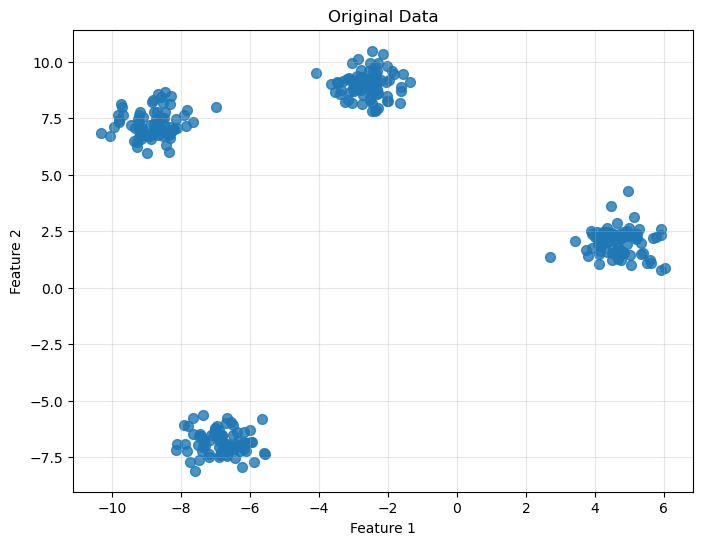

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs, load_iris, load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples

# 创建示例数据
X, y_true = make_blobs(n_samples=300, centers=4, n_features=2,
                       cluster_std=0.6, random_state=42)

# 可视化原始数据
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=50, alpha=0.8)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Original Data')
plt.grid(True, alpha=0.3)
plt.show()

# 应用K-Means
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto') # Added n_init for future versions
y_kmeans = kmeans.fit_predict(X)

# 可视化聚类结果
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis', alpha=0.8)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.8,
            marker='*', edgecolor='black', linewidth=2)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-Means Clustering Results')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Cluster centers:\n{centers}")
print(f"Inertia (within-cluster sum of squares): {kmeans.inertia_:.2f}")
